In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#linear regression: 
from sklearn.linear_model import LinearRegression


In [2]:
import sys
sys.path.append('./models/')
df=pd.read_csv('hopitalized_and_infectious.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
n_hospitalized=np.array(df['hospitalized'])
n_infectious=np.array(df['n_infectious'])


# importing mobility from the csv file
df_mobility=pd.read_csv('mobility_bis.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])

relier_les_points=[]
for i in range(len(mobility)): 
    if i + 7 < len(mobility): 
        if i % 7 ==0:
            relier_les_points.append(mobility[i])
        else: 
            decalage=i-7*(i//7)
            res = (1-decalage/7)*mobility[7*(i//7)] + (decalage/7)*mobility[7*(i//7)+7]

            relier_les_points.append(res)
    else:
        relier_les_points.append(mobility[i])
mobility_smoothed=np.array(relier_les_points)
data3D=np.array([n_hospitalized, n_infectious, mobility_smoothed])





In [3]:
split=200
data_train=np.array([n_infectious[:split], mobility_smoothed[:split]]).T

In [4]:
data_train.shape

(200, 2)

[[ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]
 [ 4.20860960e+04 -3.36462857e-01]]


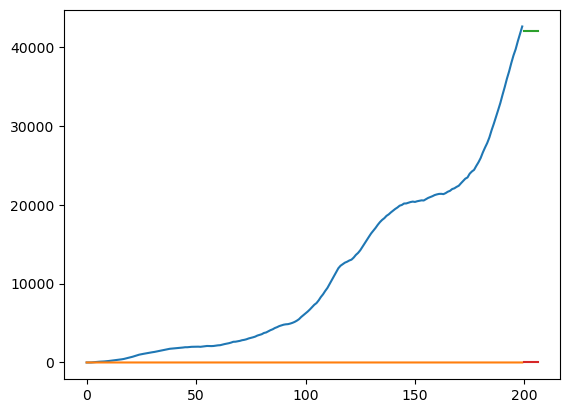

In [5]:
rf=RandomForestRegressor(max_depth=100,  n_estimators=1000)
rf.fit(np.array([i for i in range(split)]).reshape(-1, 1), data_train)
predict=rf.predict(np.array([i for i in range(split, split+7)]).reshape(-1, 1))
print(predict)
plt.plot([i for i in range(split)], data_train, label='train')
plt.plot([i for i in range(split, split+7)], predict, label='predict')

In [9]:
x=np.arange(0, 5, 0.01)
y=3*x+2 + np.random.normal(0, 1, len(x))

# train, test split : 

x_train=[]
y_train=[]
x_test=[]
y_test=[]
for i in range(len(x)):
    if np.random.random() < 0.8: 
        x_train.append(x[i])
        y_train.append(y[i])
    else:
        x_test.append(x[i])
        y_test.append(y[i])
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)



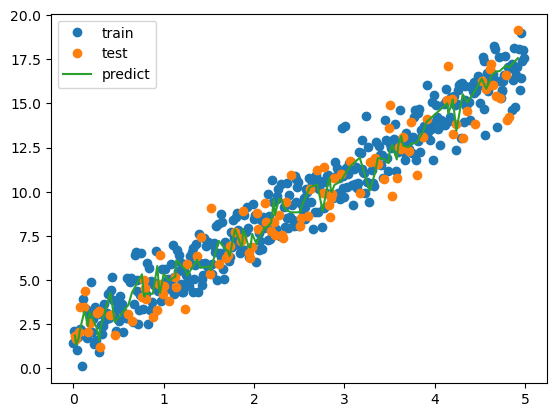

In [11]:



# rf to fit the data : 
rf=RandomForestRegressor(max_depth=10,  n_estimators=100)
rf.fit(x_train.reshape(-1, 1), y_train)
predict=rf.predict(x_test.reshape(-1, 1))

plt.plot(x_train, y_train,'o',  label='train')
plt.plot(x_test, y_test, 'o', label='test')
plt.plot(x_test, predict, label='predict')
plt.legend()
plt.show()


In [175]:
split=250

In [176]:
number_of_points=10
data_rf=[]
y_rf=[]
for i in range(number_of_points, len(n_hospitalized)): 
    data_rf.append(n_hospitalized[i-number_of_points:i])
    y_rf.append(n_hospitalized[i])
data_rf=np.array(data_rf)


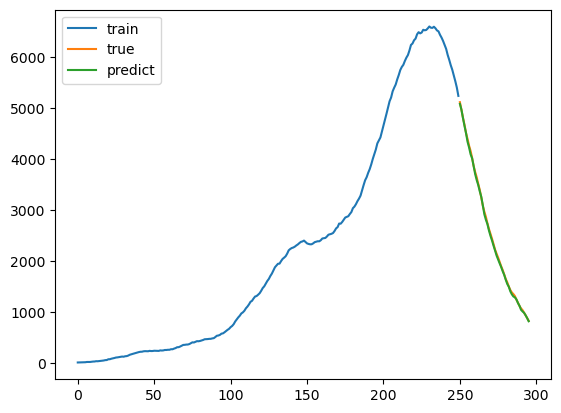

In [177]:
lr=LinearRegression()
lr.fit(data_rf[:split], y_rf[:split])
predict=lr.predict(data_rf[split:])
plt.plot(y_rf[:split], label='train')
plt.plot([i for i in range(split, len(data_rf))], y_rf[split:], label='true')
plt.plot([i for i in range(split, len(data_rf))],  predict, label='predict')
plt.legend()

In [178]:
datatrain=data_rf[:split]
y_train=y_rf[:split]
data_test=data_rf[split:]

In [179]:
rf=RandomForestRegressor(max_depth=5,  n_estimators=100)
rf.fit(datatrain, y_train)
predict=[rf.predict(data_test[i].reshape(1, -1)) for i in range(10)]


In [ ]:
def predict_model(model, data_train, reach): 
    

In [180]:
# prediction 7 days ahead : 
prediction_7_days=[]
predict=rf.predict(data_test[0].reshape(1, -1))
prediction_7_days.append(predict)
last_day=np.array(datatrain[-1])
print(len(last_day))
for i in range(1, 7):
    last_day=np.concatenate((last_day[1:], predict))
    predict = rf.predict(last_day.reshape(1, -1))
    prediction_7_days.append(predict)
prediction_7_days=np.array(prediction_7_days)


10


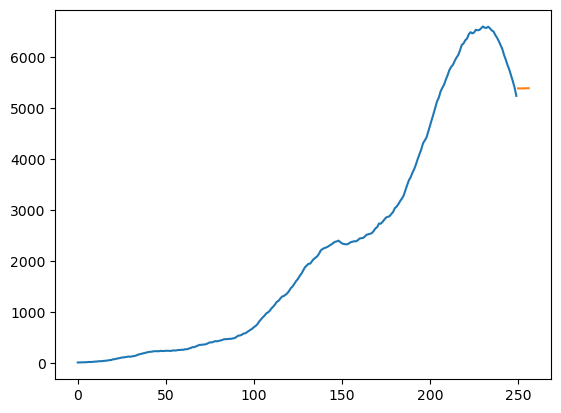

In [181]:
plt.plot(y_train)
plt.plot([i + split for i in range(7)], prediction_7_days, label='predict')

In [182]:
last_day, predict
last_day+predict

array([11130.78678341, 11017.78678341, 10904.78678341, 10779.78678341,
       10763.90523349, 10763.90523349, 10763.90523349, 10763.90523349,
       10766.22356682, 10766.22356682])

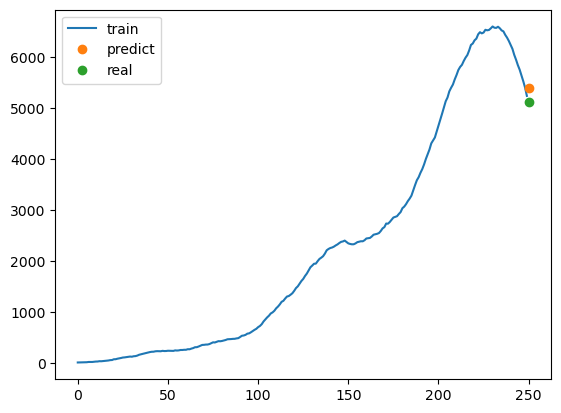

In [183]:
plt.plot([i for i in range((split))], y_rf[:split], label='train')
plt.plot([split], predict,'o',  label='predict')
plt.plot([split], y_rf[split],'o',  label='real')
plt.legend()


In [184]:
gb=GradientBoostingRegressor(max_depth=10,  n_estimators=20)
gb.fit(data_rf[:split], y_rf[:split])
predict=gb.predict(data_rf[split].reshape(1, -1))

